In [1]:
#=============Endothelial:ec+lec==============  
library(Seurat)
library(tidyverse)
library(doParallel)
library(patchwork)

library(scales)
library(slingshot)
library(monocle3)
library(tradeSeq)

library(ggplot2)
library(forcats) # 和 ggplot 一起给数据排序
library(ggrepel)
library(viridis)
library(ggpubr)

library("GSEABase")
library(AUCell)
library(Matrix) 
source("/share/home/qlab/projects/qlab_yrs/scTools.R")
source("/share/home/qlab/projects/qlab_yrs/scPlot.R")
library(ComplexHeatmap)

Attaching SeuratObject

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Warning message:
“package ‘iterators’ was built under R version 4.1.2”
Loading required package: parallel


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_f

In [2]:
library(msigdbr)
library(fgsea)
mdb_c2 <- msigdbr(species = "Homo sapiens", category = "C2")
mdb_rec = mdb_c2 [grep("^REACTOME",mdb_c2 $gs_name),]
## 预定义基因集：KEGG+rectome
mdb_c2 <- msigdbr(species = "Homo sapiens", category = "C2")
mdb_kegg = mdb_c2 [grep("^KEGG",mdb_c2 $gs_name),]
mdb_rec = mdb_c2 [grep("^REACTOME",mdb_c2 $gs_name),]
fgsea_kegg_sets <- mdb_kegg %>% split(x = .$gene_symbol, f = .$gs_name)
fgsea_rec_sets <- mdb_rec %>% split(x = .$gene_symbol, f = .$gs_name)
library("hypeR")
# gc()
#draw network
options(browser = "xdg-open")
biosets  <- list()
biosets[["BIOCARTA"]] <- msigdb_gsets(species="Homo sapiens", category="C2", subcategory="CP:BIOCARTA")
biosets[["KEGG"]]     <- msigdb_gsets(species="Homo sapiens", category="C2", subcategory="CP:KEGG")
biosets[["REACTOME"]] <- msigdb_gsets(species="Homo sapiens", category="C2", subcategory="CP:REACTOME")
biosets[["GO"]] <- msigdb_gsets(species="Homo sapiens", category="C5", subcategory="BP")

Warning message:
“程辑包‘hypeR’是用R版本4.3.0 来建造的”


In [24]:
# --- Add annotations for a specific clustering
immune@meta.data$EC_CellType <- as.character(immune@meta.data$EC_CellType)
immune@meta.data$EC_CellType[which(immune@meta.data$EC_CellType == 'extra-alveolar capillary')] <- 'Extra-alveolar capillary'
immune@meta.data$EC_CellType[which(immune@meta.data$EC_CellType == 'immature')] <- 'Immature'
immune@meta.data$EC_CellType[which(immune@meta.data$EC_CellType == 'vein')] <- 'Vein'
immune@meta.data$EC_CellType[which(immune@meta.data$EC_CellType == 'artery')] <- 'Artery'
immune@meta.data$Site[is.na(immune@meta.data$Site)] <- 'lung'
immune@meta.data$Site[which(immune@meta.data$Site == 'UP')] <- 'lung_UP'
immune@meta.data$Site[which(immune@meta.data$Site == 'LOW')] <- 'lung_LOW'
immune@meta.data$Age[which(immune@meta.data$SamNum %in% c('SScJ1', 'SScJ2'))] <- '54'

ct.res <- data.frame(EC_CellType = immune@meta.data$EC_CellType %>% as.character() %>% unique(),
                     celltype.res.0.1 = 0:(length(immune@meta.data$EC_CellType %>% as.character() %>% unique()) - 1))
meta <- immune@meta.data
immune@meta.data <- meta %>% 
                    rownames_to_column(var = 'barcode') %>%
                    left_join(ct.res, by = 'EC_CellType') %>%
                    column_to_rownames(var = 'barcode')

DefaultAssay(immune) <- 'RNA'
Idents(immune) <- 'celltype.res.0.1'
markers <- FindAllMarkers(immune, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
saveRDS(markers, file = paste0('SnnGenes/ct_res.0.1.rds.gz'), compress = "gzip")

saveRDS(immune, './endothelial.rds')

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5



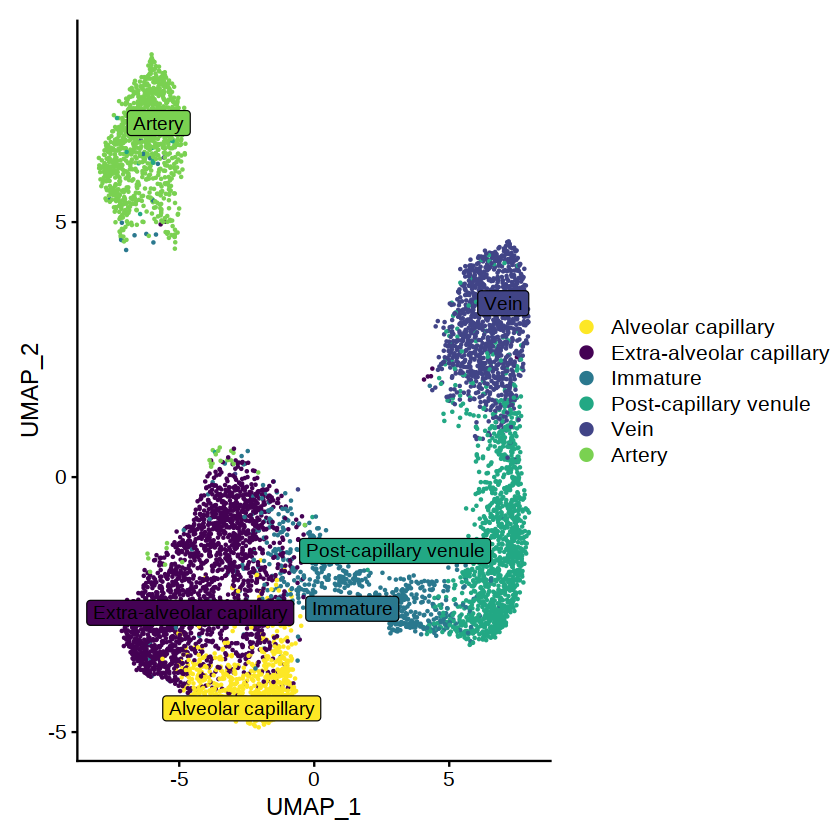

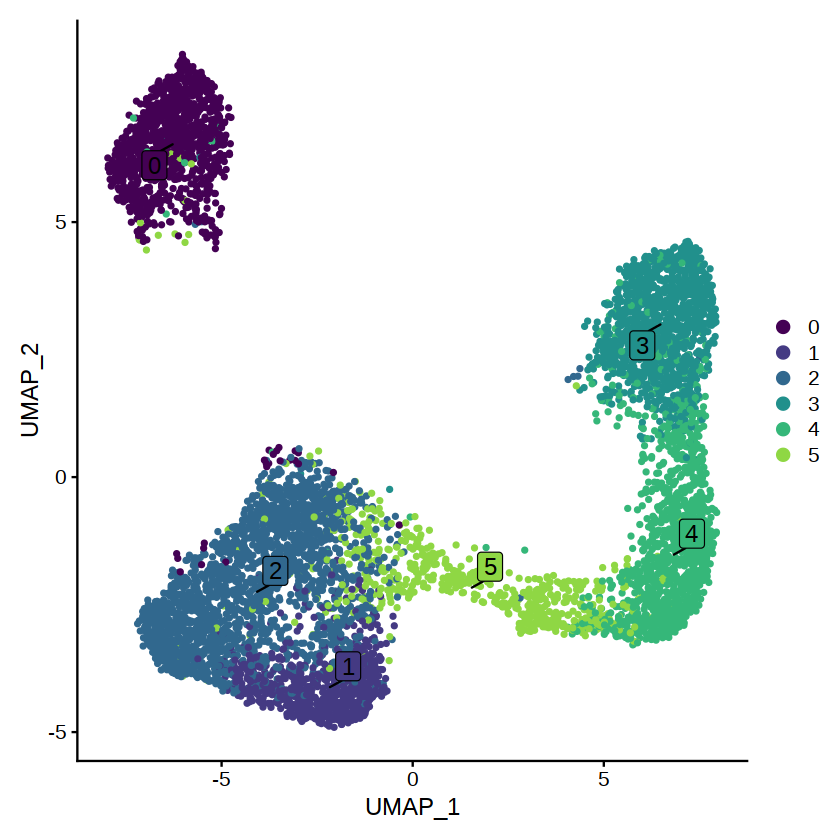

In [2]:
# ssc <- readRDS("/share/home/qlab/projects/qlab_yrs/project_ssc/data/object/all/sam_df_anno_SSC.rds")
immune <- readRDS("./endothelial.rds")
ct.order <- c('Alveolar capillary', 'Extra-alveolar capillary', 'Immature', 'Post-capillary venule', 'Vein', 'Artery')
# pdf('./figures/newEC_umap.pdf', width = 7, height = 5)
immune@meta.data$EC_CellType <- factor(immune@meta.data$EC_CellType,
                                              levels = ct.order)
col.use <- c('#FDE725FF', '#440154FF',  '#2A788EFF', '#22A884FF', '#414487FF', '#7AD151FF')
Idents(immune) <- "EC_CellType"
DimPlot(immune, reduction = "umap",label=TRUE,label.size=4, 
        label.color = "black",
        label.box = TRUE, 
        repel = TRUE, cols = col.use)
# dev.off()
# pdf('./figures/newEC_mt.pdf', width = 6, height = 5)
# DefaultAssay(immune.cluster) <- "RNA"
# FeaturePlot(immune.cluster, features=c("percent.mt"))
# dev.off()
# pdf('./figures/newEC_rna.pdf', width = 6, height = 5)
# FeaturePlot(immune.cluster, features=c("nFeature_RNA"))
# dev.off()

Idents(immune) <- 'celltype.res.0.1'
DimPlot(immune, reduction = "umap", label=TRUE, label.size=5,  cols = viridis(7, option = "D"), 
        label.color = "black", label.box = TRUE, pt.size = 1, raster = FALSE, repel = TRUE) 

In [14]:
# --- CCA quality control
sam.col <- c( '#66ABA5',  '#438E5C',  '#677999',  '#BD1410',  '#1E2351',  '#156D5D', 
             '#D2BE7F',  '#603725',  '#C9551A',  '#B61314',  '#434770',  '#496998', 
             '#7C0511',  '#9F4B56',  '#B5454F',  '#291821',  '#791D3C',  '#9D0D10', 
             '#CB6B40',  '#CC5C59',  '#D1A089',  '#A1B586',  '#E4E1D6',  '#A8825B',  '#9BD1BE')
pdf(file="./figures/sample_umap.pdf", width=9)
Idents(immune.cluster) <- "SamNum"
DimPlot(immune.cluster, reduction = "umap",label = FALSE,label.size=4,raster = FALSE,label.box=FALSE,repel=TRUE, shuffle=TRUE, cols=sam.col, pt.size = 1)
dev.off()

# pdf(file="./figures/Tissue_umap.pdf", width=8)
# Idents(immune.cluster) <- "Tissue"
# DimPlot(immune.cluster, reduction = "umap",label = FALSE,label.size=4,raster = FALSE,label.box=FALSE,repel=TRUE, shuffle=TRUE, cols=(viridis(3, option = "E")))
# dev.off()

# pdf(file="./figures/Cohort_umap.pdf", width=8)
# Idents(immune.cluster) <- "Cohort"
# DimPlot(immune.cluster, reduction = "umap",label = FALSE, pt.size=0.1, raster = FALSE,label.box=FALSE,repel=TRUE, shuffle=TRUE, cols=c('#FFF0DC', '#FF9900', '#336699'))
# dev.off()


# pdf(file="/share/home/qlab/projects/qlab_yrs/project_ssc/result/Umap/SSC_Combine/all_umap.pdf")
# Idents(immune.cluster) <- "CellType"
# DimPlot(immune.cluster, reduction = "umap",label = TRUE,label.size=4,label.box=FALSE,repel=TRUE,shuffle=TRUE) + NoLegend()
# dev.off()

# pdf(file="/share/home/qlab/projects/qlab_yrs/project_ssc/result/Umap/SSC_Combine/health_umap.pdf")
# Idents(immune.health) <- "CellType"
# DimPlot(immune.health, reduction = "umap",label = TRUE,label.size=4,label.box=FALSE,repel=TRUE,shuffle=TRUE) + NoLegend()
# dev.off()

# pdf(file="/share/home/qlab/projects/qlab_yrs/project_ssc/result/Umap/SSC_Combine/ssc_umap.pdf")
# Idents(immune.ssc) <- "CellType"
# DimPlot(immune.ssc, reduction = "umap",label.size=4,label=TRUE,label.box=FALSE,repel=TRUE,shuffle=TRUE) + NoLegend()
# dev.off()

pdf(file="./figures/Group_umap.pdf", width = 7)
Idents(immune.cluster) <- "Group"
# DimPlot(immune.cluster, reduction = "umap",label.size=4,label=FALSE,label.box=FALSE,repel=TRUE,shuffle=TRUE) + NoLegend()
DimPlot(immune.cluster, reduction = "umap",pt.size = 1, label.size=4,label=FALSE,label.box=FALSE,repel=TRUE,shuffle=TRUE, cols=(viridis(2, option = "D")))
dev.off()

png 
  2

png 
  2

In [17]:
pdf('./figures/newEC_mt.pdf', width = 24, height = 15)
DefaultAssay(immune.cluster) <- "RNA"
FeaturePlot(immune.cluster, features=c("percent.mt", "nFeature_RNA",
                                       "ACKR1", "FBLN5", "HPGD", 
                                       "FCN3", "IL1R1","POSTN",
                                       "RGS5","CXCL12","DCN"), pt.size = 1)
dev.off()

png 
  2

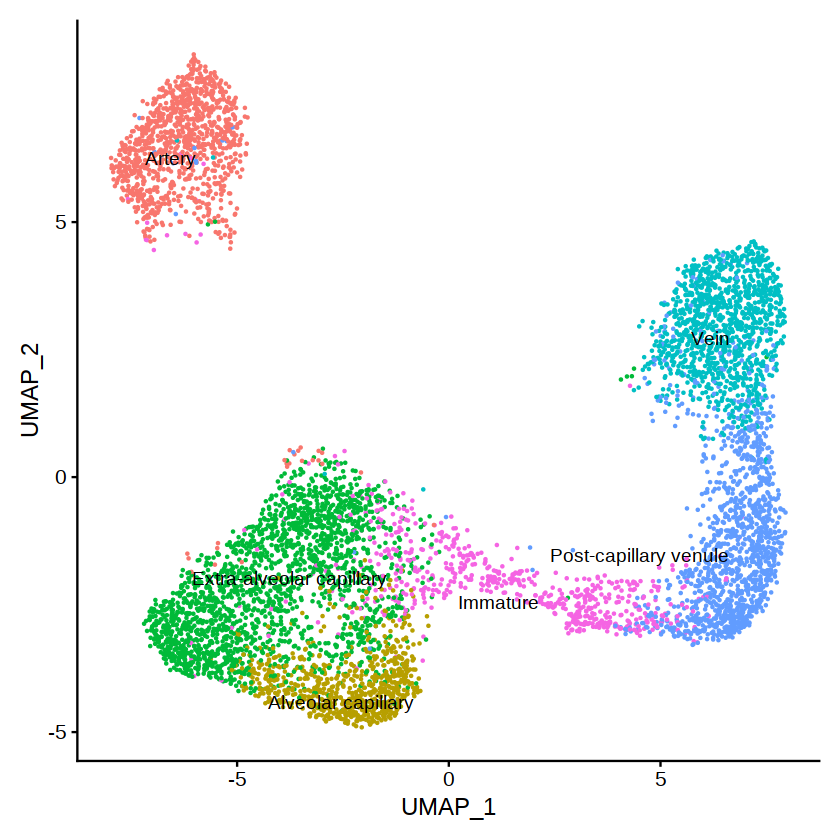

In [4]:
immune.cluster <- readRDS('endothelial.rds')
Idents(immune.cluster) <- "EC_CellType"
DimPlot(immune.cluster, reduction = "umap",label = TRUE,label.size=4,label.box=FALSE,repel=TRUE,shuffle=TRUE) + NoLegend()

In [5]:
# DefaultAssay(immune.cluster) <- "RNA"
# Idents(immune.cluster) <- "EC_CellType"
# markers <- FindAllMarkers(immune.cluster, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
# write.csv(markers, file="SubCellType_Top_Genes.csv")

`summarise()` has grouped output by 'SampleID'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'SampleID', 'Group'. You can override using the `.groups` argument.


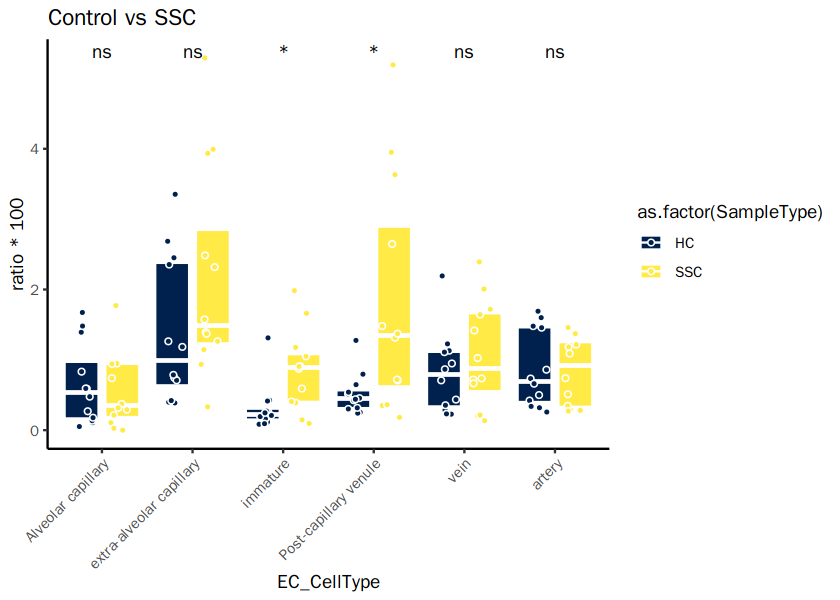

In [8]:
## 绘制 Control 和 SSC 样本中不同细胞类型的差异
ssc <- readRDS("/share/home/qlab/projects/qlab_yrs/project_ssc/data/object/all/ssc_lung_all_celltypes.rds")#sam_df_anno_SSC.rds")
ct.order <- c('Alveolar capillary', 'extra-alveolar capillary', 'immature', 'Post-capillary venule', 'vein', 'artery')
classifier  <- "Group"
metadata.df  <- immune.cluster@meta.data %>%
  tibble::rownames_to_column(var = "Cell")
cell_num.df  <- ssc@meta.data %>%
  dplyr::group_by(SampleID, !!sym(classifier)) %>%
  dplyr::summarise(total = n()) %>%
  dplyr::ungroup() %>%
  dplyr::rename(SampleType = 2) %>%
  dplyr::mutate(ID = paste0(SampleID,".",SampleType)) %>%
  dplyr::select(ID,total)

ratio.df  <- metadata.df %>%
  dplyr::group_by(SampleID,!!sym(classifier), EC_CellType) %>% #
  dplyr::summarise(sum = n()) %>%
  ungroup() %>%
  dplyr::rename(SampleType = 2) %>%
  tidyr::complete(nesting(SampleID, SampleType), EC_CellType, fill = list(sum = 0)) %>% #
  dplyr::mutate(ID = paste0(SampleID,".",SampleType)) %>%
  left_join(cell_num.df, by = "ID") %>%
  rowwise() %>%
  dplyr::mutate(ratio = sum / total )

ratio.df$EC_CellType <- factor(ratio.df$EC_CellType, ct.order)
# colors.use  <- scales::viridis_pal()(3)[1:2]
colors.use  <- viridis(2, option = "E")
fig.size(5,7)
ggplot(ratio.df,aes(x = EC_CellType, y = ratio * 100, fill = as.factor(SampleType))) + #
  geom_boxplot(outlier.shape = NA, position=position_dodge(width=0.9), size = 0.5, colour = "#FFFFFF") +
  geom_point(pch = 21, position = position_jitterdodge(), colour = "white", size = 1.25) +
  #   geom_jitter( size = 0.6 , position=position_dodge(width=0.9),aes(group=SampleType, alpha = 0.6)) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ggtitle("Control vs SSC") +
  scale_fill_manual(values = colors.use)+
  stat_compare_means(aes(label = after_stat(p.signif)), label.x = 10, method = "t.test") 
# ggsave('./figures/CellProp_SSCvsHC.pdf', width = 5, heigh = 4)

In [5]:
data$EC_CellType %>% unique()

[1] "Artery"                   "Alveolar capillary"      
[3] "Extra-alveolar capillary" "Vein"                    
[5] "Post-capillary venule"    "Immature"

`summarise()` has grouped output by 'EC_CellType'. You can override using the
`.groups` argument.
Warning message:
“ggrepel: 10959 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


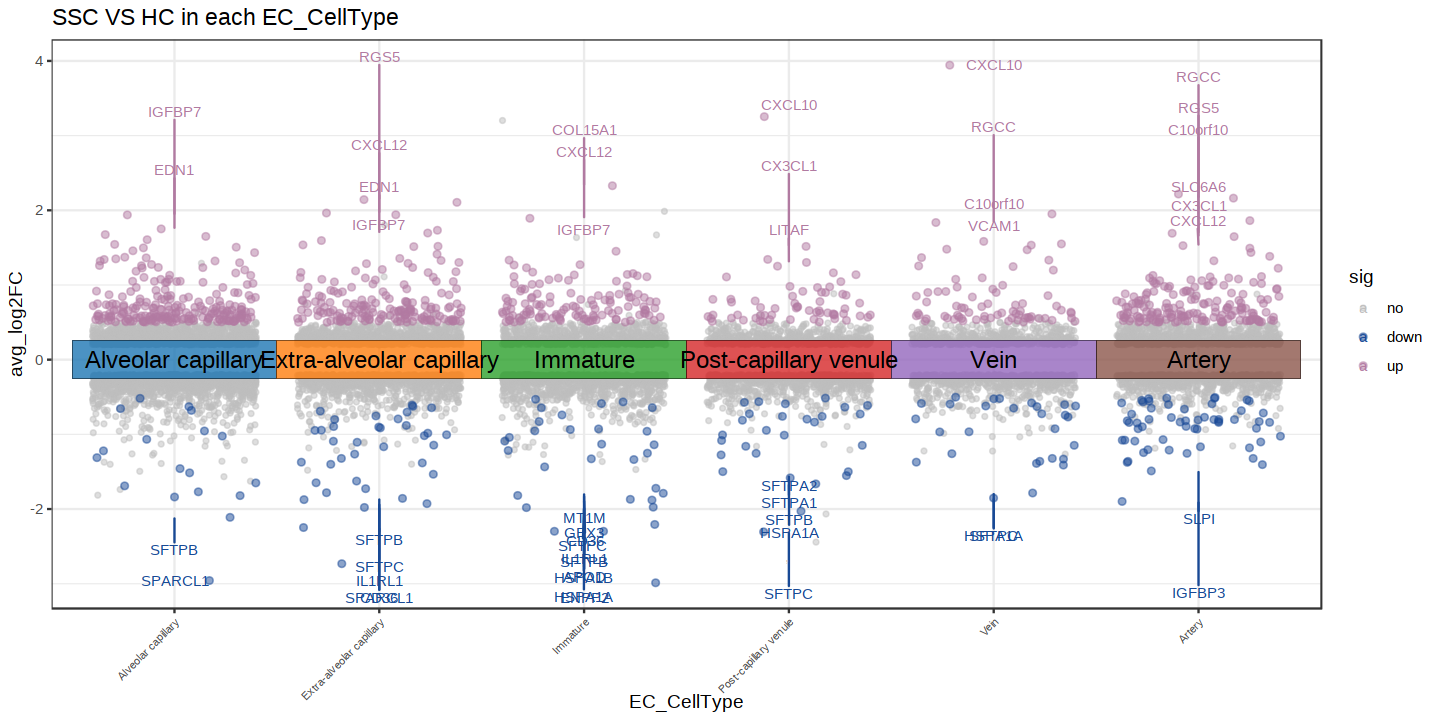

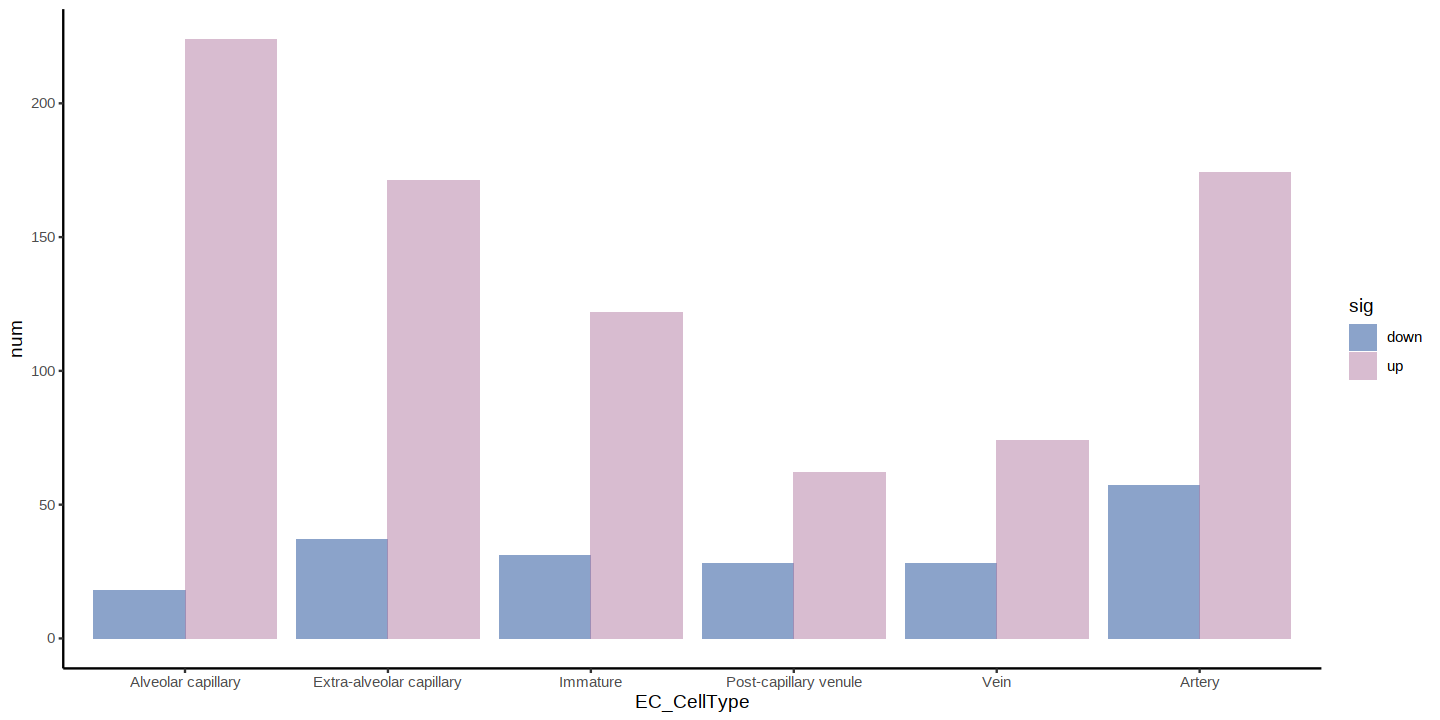

In [6]:
# # --- plot DEGs in each EC_CellType
# immune.cluster <- subset(immune.cluster, Cohort %in% c('ev', 'paul'))
# DefaultAssay(immune.cluster) <- 'RNA'
# ct.list = immune.cluster@meta.data$EC_CellType %>% unique()
# data <- NULL
# for(ct in ct.list){
#     immune.f <- subset(immune.cluster, EC_CellType == ct)
#     cell.ssc <- immune.f@meta.data %>% subset(Group == 'SSC') %>% rownames()
#     cell.hc <- immune.f@meta.data %>% subset(Group == 'HC') %>% rownames()
#     diff <- FindMarkers(immune.f, min.pct = 0.01, logfc.threshold = 0.2, ident.1 = cell.ssc, ident.2 = cell.hc) %>% rownames_to_column(var = "gene")
#     diff$EC_CellType <- ct
#     data <- rbind(data, diff)
# }
# data %>% mutate(Compare = 'SSc_VS_HC') %>%
# write.csv('Figure3.d.csv', row.names = F)
library(ggsci)
data <- read.csv('Figure3.d.csv')
diff.all <- data
diff.all$sig <- 'no'
diff.all$sig[which(diff.all$p_val_adj < 0.05 & diff.all$avg_log2FC > 0.5)] <- 'up'
diff.all$sig[which(diff.all$p_val_adj < 0.05 & diff.all$avg_log2FC < -0.5)] <- 'down'
diff.all$label <- ', '
diff.all$label[which(diff.all$sig %in% c('down', 'up'))] <- diff.all$gene[which(diff.all$sig %in% c('down', 'up'))] 
diff.all$EC_CellType <- factor(diff.all$EC_CellType,
                              levels = c('Alveolar capillary', 'Extra-alveolar capillary', 'Immature', 'Post-capillary venule', 'Vein', 'Artery'))

ct.list <- c('Alveolar capillary', 'Extra-alveolar capillary', 'Immature', 'Post-capillary venule', 'Vein', 'Artery')
dfcol<- data.frame(x = ct.list, y = 0, label = ct.list)
dfcol$label <- factor(dfcol$label, levels = ct.list)
mycol <- pal_d3("category20")(6)
# --- Count DEGs numbers
deg.num.df <- diff.all %>% dplyr::filter(sig %in% c('up', 'down')) %>% 
                group_by(EC_CellType, sig) %>% summarise(num = n()) %>%
                as.data.frame() %>% mutate(num_new = ifelse(sig == 'up', num, -num))
# --- set specifically displayed genes
hypoxia.rec.genesets <- c('ARNT', 'CA9', 'CREBBP', 'EP300', 'EPAS1', 'EPO', 'HIF1A', 'ELOC', 'ELOB', 'VEGFA', 
                          'VHL','CUL2', 'RBX1', 'CITED2', 'HIGD1A', 'HIF1AN', 'HIF3A', 'EGLN2', 'EGLN3')
diff.all$label_hypo <-', '
diff.all$label_hypo[which(diff.all$gene %in% hypoxia.rec.genesets)] <- diff.all$gene[which(diff.all$gene %in% hypoxia.rec.genesets)]
diff.all$label_hypo[which(diff.all$sig == 'no')] <- ', '

O2_CO2.rec.genesets <- c('AQP1', 'CA1', 'CA2', 'CA4', 'HBA2', 'HBB', 'RHAG', 'SLC4A1')
diff.all$label_o2 <-', '
diff.all$label_o2[which(diff.all$gene %in% O2_CO2.rec.genesets)] <- diff.all$gene[which(diff.all$gene %in% O2_CO2.rec.genesets)]
diff.all$label_o2[which(diff.all$sig == 'no')] <- ', '

options(repr.plot.height = 6, repr.plot.width = 12)
diff.all$sig = factor(diff.all$sig, levels = c('down', 'no', 'up'))
ggplot()+
    # --- plot total degs
    # geom_bar(data= deg.num.df, aes(x = EC_CellType, y = num_new/100), stat="identity", fill = 'grey', alpha = 0.5) + 
    # geom_text(data= deg.num.df, aes(x = EC_CellType, y = num_new/100, label = num), vjust = -0.5)+
    # --- plot dot
    geom_jitter(data = diff.all %>% dplyr::filter(sig == "no"), 
                aes(x = EC_CellType, y = avg_log2FC, color = sig), size = 1, width = 0.4, alpha = 0.5) +
    geom_jitter(data = diff.all %>% dplyr::filter(sig %in% c('down', 'up')), # %>% dplyr::filter(label_hypo == ', ' & label_o2 == ', '), 
                aes(x = EC_CellType, y = avg_log2FC, color = sig), size = 1.5, width = 0.4, alpha = 0.5) +  
    # geom_jitter(data = diff.all %>% dplyr::filter(label_hypo != ', '), 
    #             aes(x = EC_CellType, y = avg_log2FC), size = 2, stroke = 0.5, shape = 21, color = 'black', fill = '#6B8770', width = 0.4, alpha = 0.75) +
    # geom_jitter(data = diff.all %>% dplyr::filter(label_o2 != ', '), 
    #             aes(x = EC_CellType, y = avg_log2FC), size = 2, stroke = 0.5, shape = 21, color = 'black', fill = 'orange', width = 0.4, alpha = 0.75) +
    scale_color_manual(values = c("grey","#184995","#B17AA1")) +
    # --- plot label
    geom_text_repel(data = diff.all, #%>% dplyr::filter(label_hypo == ', ' & label_o2 == ', '), 
                    aes(x = EC_CellType, y = avg_log2FC, label=label, color = sig), 
                    size = 3, force = 0.5, max.overlaps = 15) +
    # geom_text(data = diff.all %>% dplyr::filter(label_hypo != ', '), 
    #                 aes(x = EC_CellType, y = avg_log2FC, label=label_hypo), 
    #                 size = 3, color = 'black', force = 0.5, max.overlaps = 15
    #                )+
    # geom_text(data = diff.all %>% dplyr::filter(label_o2 != ', '), 
    #                 aes(x = EC_CellType, y = avg_log2FC, label=label_o2),
    #                 size = 3, color = 'black', force = 0.5, max.overlaps = 15, 
    #                 arrow = arrow(length = unit(0.008, "npc"), type = "open", ends = "last")
    #                )+
    geom_tile(data = dfcol, aes(x=x, y=y), height=0.5, color = "black", fill = mycol, alpha = 0.8, show.legend = F) +
    geom_text(data = dfcol, aes(x=x, y=y,label=x), size = 5 , color ="black") +
    labs(x="EC_CellType", y="avg_log2FC") +
    # scale_y_continuous(sec.axis = sec_axis(~.*100, name = 'number of sigDEGs')) +
    theme_bw() +  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) +
    ggtitle('SSC VS HC in each EC_CellType') 
# ggsave('./figures/DEGs_in_EC_CellType.pdf', width = 7, heigh = 5)

ggplot() + 
geom_bar(data= deg.num.df, aes(x = EC_CellType, y = num,  fill = sig), stat="summary", fun='mean', position = position_dodge(), alpha = 0.5) +
scale_fill_manual(values = c("#184995", "#B17AA1")) +
theme_classic()
# ggsave('./figures/DEGsNumber_in_ECCellType.pdf', width = 7, heigh = 5)

In [6]:
# Enriched Pathway in SSC of each EC_CellType
diff.all <- data
ct.list <- c('artery', 'alveolar capillary', 'extra-alveolar capillary', 'vein', 'post-capillary venule', 'immature')
for(i in seq_along(ct.list)){
    c1.gene = diff.all %>% dplyr::filter(p_val < 0.05 & avg_log2FC > 0 & EC_CellType == ct.list[i]) %>% 
            arrange(-avg_log2FC) %>% pull(gene) %>% .[1:200]
    geneset  <- biosets[['REACTOME']]
    if(length(geneset$genesets[duplicated(geneset$genesets)]) >0){geneset$genesets <- geneset$genesets[!duplicated(geneset$genesets)]}
    hyp_obj <- hypeR(c1.gene, geneset,test="hypergeometric", background=30000)
    hyp_obj$data$label <- str_replace(hyp_obj$data$label, 'REACTOME_', ', ')
    
    pdf(paste0('./figures/ct_reactome/', ct.list[i], '_plot.pdf'), width = 4, height = 6)
    p.plot <- hyp_obj$data %>% dplyr::filter(fdr < 0.01 & pval < 0.05 & overlap > 9) %>% 
            mutate(pathway = fct_reorder(label, -fdr), GeneNum = overlap) %>%
            ggplot(aes(x = -log(pval), y = pathway)) +
                geom_point(aes(size = GeneNum, color = -log(fdr))) +
                scale_color_gradient(low="#136885",high = "#FAB35B") +
                theme_bw() + labs(color = "-Log(FDR)") +
                ggtitle(paste0(gsub("(\\D)(\\D+)", "\\U\\1\\L\\2", ct.list[i], perl = TRUE),': enriched Reactome pathways')) + 
                theme(axis.text.y = element_blank())
    print(p.plot)
    dev.off()
        
    pdf(paste0('./figures/ct_reactome/', ct.list[i], '_yaxis.pdf'), width = 12, height = 6)        
    p.y <- hyp_obj$data %>% dplyr::filter(fdr < 0.01 & pval < 0.05 & overlap > 9) %>% 
            mutate(pathway = fct_reorder(label, -fdr), GeneNum = overlap) %>%
            ggplot(aes(x = -log(pval), y = pathway)) +
                geom_point(aes(size = GeneNum, color = -log(fdr))) +
                scale_color_gradient(low="#136885",high = "#FAB35B") +
                theme_bw() + labs(color = "-Log(FDR)") +
                ggtitle(paste0(gsub("(\\D)(\\D+)", "\\U\\1\\L\\2", ct.list[i], perl = TRUE),': enriched Reactome pathways')) 
    print(p.y)
    dev.off()
}

In [7]:
# # --- Calculate Hypoxia Scores
# genes.hypoxia <- c("VEGFA", "SLC2A1", "PGAM1", "ENO1", 
#                 "LDHA", "TPI1", "P4HA1", "MRPS17",
#                 "CDKN3", "ADM", "NDRG1", "TUBB6",
#                 "ALDOA", "MIF", "ACOT7")
# immune.cluster <- AddModuleScore(
#                  object = immune.cluster,
#                  features = list(genes.hypoxia),
#                  ctrl = length(genes.hypoxia),
#                  name = 'Hypoxia_1.Score')

# hypo.genes <- c('HIF1A', 'VEGFA', 'VEGFB', 'VEGFC',  'KDR', 'VWA1', 'ESM1', 'INSR', "VEGFA", "SLC2A1", "PGAM1", "ENO1", 
#                 "LDHA", "TPI1", "P4HA1", "MRPS17",
#                 "CDKN3", "ADM", "NDRG1", "TUBB6",
#                 "ALDOA", "MIF", "ACOT7") %>% unique()
# immune.cluster <- AddModuleScore(
#                  object = immune.cluster,
#                  features = list(hypo.genes),
#                  ctrl = length(hypo.genes),
#                  name = 'Hypoxia_2.Score')

# Idents(immune.cluster) <- 'EC_CellType'
# FeaturePlot(immune.cluster, features = c('Hypoxia_1.Score1', 'Hypoxia_2.Score1'), split.by = 'Group', pt.size = 1, order = TRUE, min.cutoff = 0)

# Idents(immune.cluster) <- 'Group'
# immune.cluster@meta.data$EC_CellType <- factor(immune.cluster@meta.data$EC_CellType,
#                                               levels = c('alveolar capillary', 'extra-alveolar capillary', 'immature', 'post-capillary venule', 'vein', 'artery'))
# # pdf(file='./figures/Features_Vln_sup.pdf', width = 6, height = 3)
# VlnPlot(immune.cluster, features =c('Hypoxia_2.Score1', 'Hypoxia_1.Score1'), stack=TRUE, flip = T, adjust = 2, # CellFeatures:"IL1R1", "POSTN", "CXCL12", "FCN3", "EDNRB"
#         cols =  c("#184995","#B17AA1"), split.by = 'Group', group.by = 'EC_CellType') +
#   stat_summary(fun = mean, geom='point', size = 10, colour = "black", shape = 95, position =  position_dodge(width = 0.9))
# # ggsave('./figures/all/vln_indir_sal.pdf', height = 4, width = 5)

In [26]:
#----------VlnFeaturePlot： hypoxia--------- 
options(repr.plot.height = 5, repr.plot.width = 6)
DefaultAssay(immune.cluster) <- 'RNA'
Idents(immune.cluster) <- 'Group'
immune.cluster@meta.data$EC_CellType <- factor(immune.cluster@meta.data$EC_CellType,
                                              levels = c('Alveolar capillary', 'extra-alveolar capillary', 'immature', 'Post-capillary venule', 'vein', 'artery'))
pdf(file='./figures/Features_Vln_sup.pdf', width = 6, height = 3)
VlnPlot(immune.cluster, features = c( "HIF1A", "EPAS1"), slot = "data", stack=TRUE, flip = T, adjust = 2, # CellFeatures:"IL1R1", "POSTN", "CXCL12", "FCN3", "EDNRB"
        cols =  c("#184995","#B17AA1"), split.by = 'Group', group.by = 'EC_CellType')
dev.off()

png 
  2

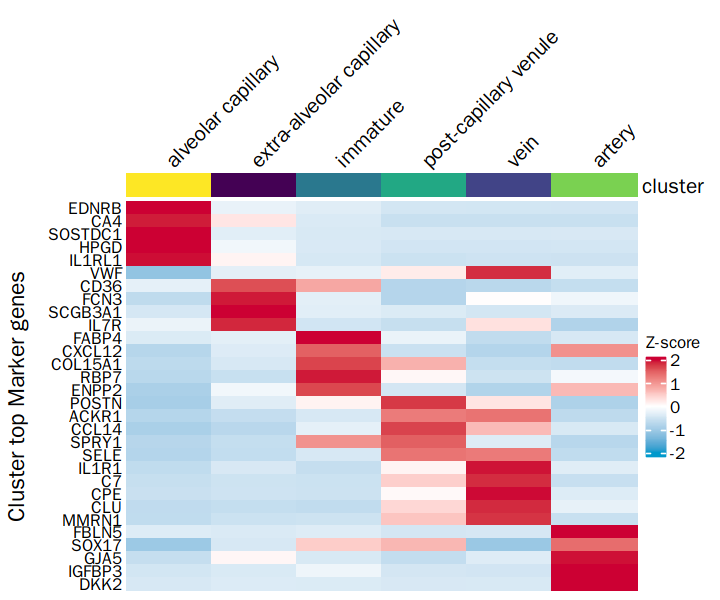

In [174]:
# # --- AverageHeatmap for top 5 genes in each clusters
# Idents(immune.cluster) <- 'EC_CellType'
# immune.cluster@meta.data$EC_CellType <- factor(immune.cluster@meta.data$EC_CellType,
#                                               levels = c('alveolar capillary', 'extra-alveolar capillary', 'immature', 'post-capillary venule', 'vein', 'artery'))
# markers <- FindAllMarkers(immune.cluster, assay = 'RNA', only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
# top10 <- markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
mrk.genes <- c('EDNRB', 'CA4', 'SOSTDC1','HPGD', 'IL1RL1', # alveolar capillary
               'VWF','CD36', 'FCN3', 'SCGB3A1', 'IL7R', # extra-alveolar capillary
               'FABP4', 'CXCL12', 'COL15A1', 'RBP7', 'ENPP2', # Immature
               'POSTN', 'ACKR1', 'CCL14', 'SPRY1', 'SELE', # post-capillary venule
               'IL1R1', 'C7', 'CPE', 'CLU', 'MMRN1', # vein
               'FBLN5', 'SOX17', 'GJA5', 'IGFBP3','DKK2' # Artery            
              )
# pdf('./figures/HM_mrkgenes.pdf', width = 5,height=7)
averageHeatmap(object = immune.cluster, markerGene = mrk.genes, annoCol = TRUE, myanCol = c('#FDE725FF', '#440154FF',  '#2A788EFF', '#22A884FF', '#414487FF', '#7AD151FF'))
# dev.off()

Warning message:
“Column annotation has different order from matrix columns. Adjust the
column annotation based on column names of the matrix.”


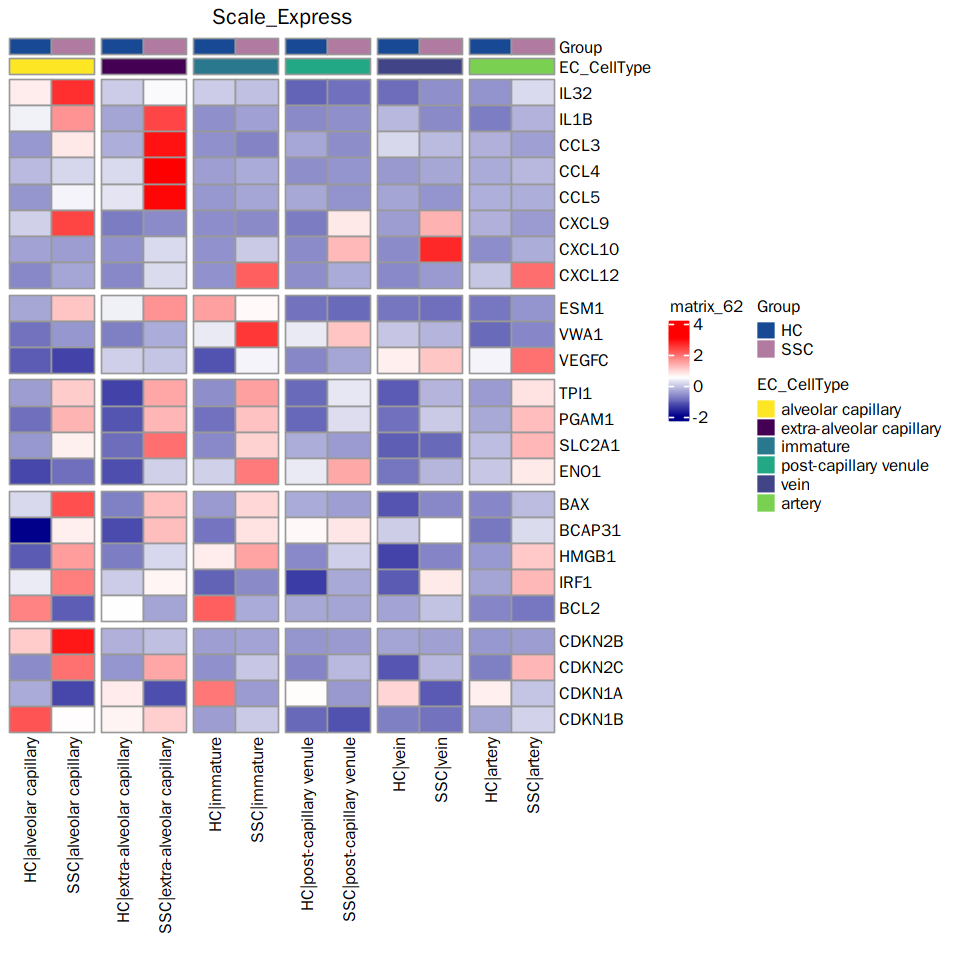

In [175]:
# --- HM：severarl pathway genes
options(repr.plot.height = 8, repr.plot.width = 8)
DefaultAssay(immune.cluster) <- 'RNA'
immune.cluster@meta.data$hm_group <- paste0(immune.cluster@meta.data$Group, '|', immune.cluster@meta.data$EC_CellType)
Idents(immune.cluster) <- 'hm_group'
immune.cluster@meta.data$hm_group <- factor(immune.cluster@meta.data$hm_group,
                                              levels = c('SSC|alveolar capillary', 'HC|alveolar capillary',
                                                         'SSC|extra-alveolar capillary', 'HC|extra-alveolar capillary',
                                                         'SSC|immature', 'HC|immature', 
                                                         'SSC|post-capillary venule', 'HC|post-capillary venule', 
                                                         'SSC|vein', 'HC|vein',
                                                         'SSC|artery', 'HC|artery'))

infm.genes <- c('IL32','IL1B', 'CCL3','CCL4','CCL5','CXCL9','CXCL10','CXCL12') # inflammatory
angio.genes <- c('ESM1', 'VWA1', 'VEGFC') # angiogensis
hypo.genes <- c('TPI1', "PGAM1", "SLC2A1", "ENO1") %>% unique() # hypoxia & angiogensis
death.genes <- c('BAX', 'BCAP31', 'HMGB1',  'IRF1',  'BCL2') %>% unique() # programmed cell death
sene.genes <- c('CDKN2B', 'CDKN2C', 'CDKN1A', 'CDKN1B') #senescence
mrk.genes <- c(infm.genes, angio.genes, hypo.genes, death.genes, sene.genes)

sam.avg <- AverageExpression(immune.cluster, assays = 'RNA', group.by = 'hm_group')
hm.df <- sam.avg$RNA %>% t() %>% as.data.frame() %>% .[, mrk.genes] %>% scale(scale = TRUE, center = TRUE)

info <- immune.cluster@meta.data[, c('hm_group', 'Group', 'EC_CellType')] %>% unique() %>% {rownames(.) <- NULL; .} %>% column_to_rownames(var = 'hm_group') 

ann_colors=list(EC_CellType = c(`alveolar capillary` = '#FDE725FF', `extra-alveolar capillary` = '#440154FF', immature = '#2A788EFF',  `post-capillary venule` = '#22A884FF', vein = '#414487FF', artery = '#7AD151FF'),
                Group = c(SSC = "#B17AA1", HC = "#184995"))
ct.list <- c('HC|alveolar capillary', 'SSC|alveolar capillary',
            'HC|extra-alveolar capillary', 'SSC|extra-alveolar capillary',
            'HC|immature', 'SSC|immature', 
            'HC|post-capillary venule', 'SSC|post-capillary venule', 
            'HC|vein', 'SSC|vein',
            'HC|artery', 'SSC|artery')
# pdf('./figures/HM_GeneExp_in_Groups.pdf', width = 10, height = 10)
hm <- pheatmap(hm.df[ct.list,] %>% t(), cluster_row = FALSE, cluster_col = FALSE, 
            color = c(colorRampPalette(colors = c("darkblue","white"))(50),colorRampPalette(colors = c("white", "red"))(50)), 
            main = ("Scale_Express"),
             annotation_col = info[,c('EC_CellType','Group')],
             annotation_colors = ann_colors,
             gaps_row = c(
                        length(infm.genes),
                        length(infm.genes) + length(angio.genes), 
                        length(c(infm.genes, angio.genes))+length(hypo.genes),
                        length(c(infm.genes, angio.genes, hypo.genes))+length(death.genes)),
            gaps_col = c(2,4,6,8,10)
            ) 
print(hm)
# dev.off()

In [12]:
# Idents(immune.cluster) <- "SamNum"
# DimPlot(immune.cluster, reduction = "umap", label=FALSE, cols = viridis(24, option = "D"), label.size=4)

# pdf('./figures/raw_group.pdf',width=8)
# DimPlot(
#   immune.cluster,
#   dims = c(1, 2),
#   cells = NULL,
#   cols = viridis(2, option = "D"),
#   pt.size = NULL,
#   reduction = 'umap',
#   group.by = 'Group',
#   split.by = NULL,
#   shape.by = NULL,
#   order = NULL,
#   shuffle = FALSE,
#   seed = 1,
#   label = FALSE,
#   label.size = 4,
#   label.color = "black",
#   label.box = TRUE, 
#   repel = TRUE,
#   cells.highlight = NULL,
#   cols.highlight = "#DE2D26",
#   sizes.highlight = 1,
#   na.value = "grey50",
#   ncol = NULL,
#   combine = TRUE,
#   raster = NULL,
#   raster.dpi = c(512, 512)
# )
# dev.off()

# pdf('./figures/raw_sample.pdf',width=8)
# DimPlot(
#   immune.cluster,
#   dims = c(1, 2),
#   cells = NULL,
#   cols = viridis(24, option = "D"),
#   pt.size = NULL,
#   reduction = 'umap',
#   group.by = 'SamNum',
#   split.by = NULL,
#   shape.by = NULL,
#   order = NULL,
#   shuffle = FALSE,
#   seed = 1,
#   label = FALSE,
#   label.size = 4,
#   label.color = "black",
#   label.box = TRUE, 
#   repel = TRUE,
#   cells.highlight = NULL,
#   cols.highlight = "#DE2D26",
#   sizes.highlight = 1,
#   na.value = "grey50",
#   ncol = NULL,
#   combine = TRUE,
#   raster = NULL,
#   raster.dpi = c(512, 512)
# )
# dev.off()

# pdf('./figures/raw_FeaturePlot.pdf', width = 20, height = 15)
# DefaultAssay(immune.cluster) <- "RNA"
# FeaturePlot(immune.cluster, features=c(
               
#                 "FBLN5", #Arterial
#                 'FCN3',
#                 "HPGD", #capillary
#                 "RGS5", #capillary
#                 "CXCL12", #immature
#                 # 'CXCR7',"FLT1","CFH","PGF","PI16","LXN","SELP","EDNRB","VWF","ETV2","TSPAN12","CLDN5", "PDPN", "PROX1","CA4","CD36",
                 
#                 "ACKR1", #HEV/venous
#                 # "VWF","EDNRB",#NEC1:VWF-
#                 # "EDN1",#NEC2&3
#                 # "IL6","CCL2","ICAM1",
               
           
#             'IL1R1','POSTN',
        
#              "AIF1","DCN","SFTPC","CD3D"#dbt)
    
# )) 
# dev.off()

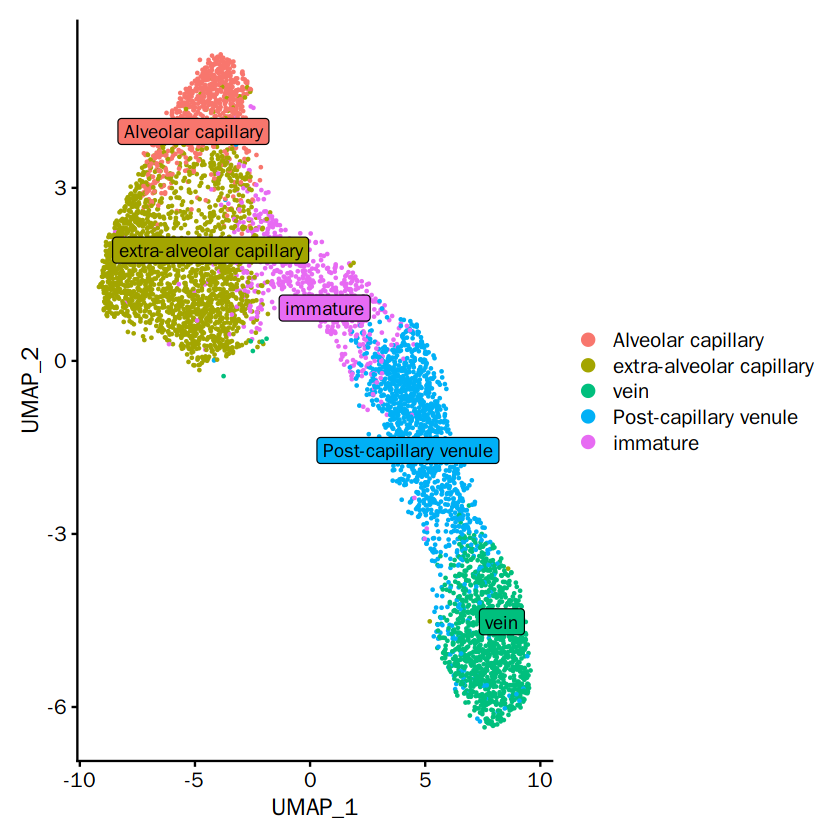

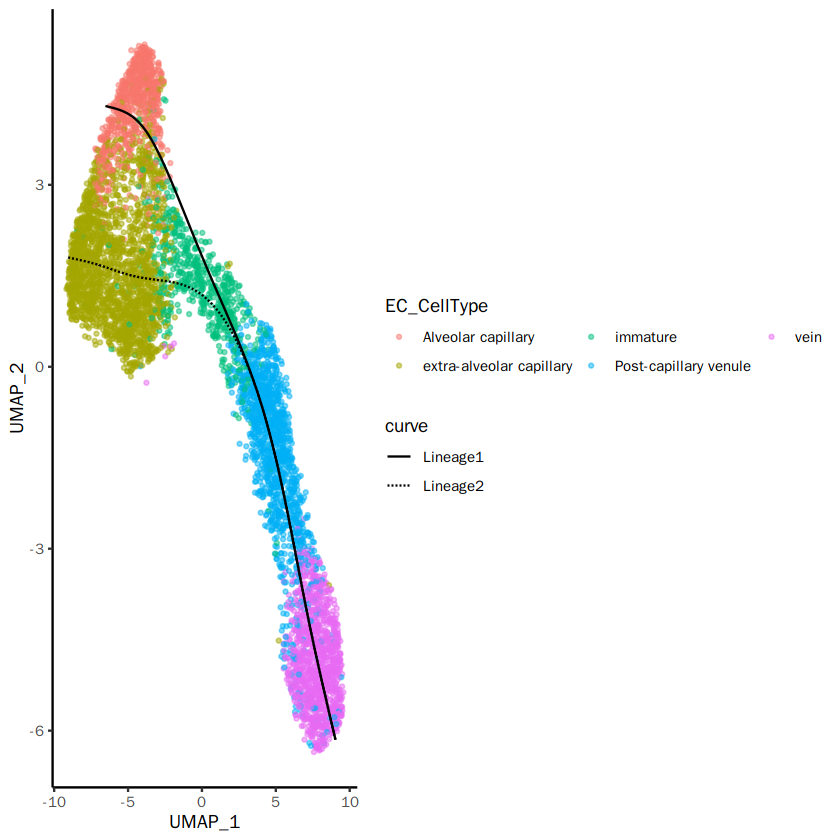

In [22]:
# --- Slingshot results
immune <- readRDS('all_assay_samples.rds')
DimPlot(immune, reduction = "umap",label=TRUE, label.size=4, 
        label.color = "black",
        label.box = TRUE, 
        repel = TRUE)
plotPseudoTime(immune, group.by = "EC_CellType", reduction = "umap",dims = 1:2, pt.size = 0.75) + theme_classic()

In [130]:
pdf('./figures/EC_umap.pdf', width = 7, height = 5)
immune.cluster@meta.data$EC_CellType <- factor(immune.cluster@meta.data$EC_CellType,
                                              levels = c('alveolar capillary', 'extra-alveolar capillary', 'immature', 'post-capillary venule', 'vein'))
col.use <- c('#FDE725FF', '#440154FF',  '#2A788EFF', '#22A884FF', '#414487FF')
Idents(immune) <- "EC_CellType"
DimPlot(immune, reduction = "umap",label=TRUE,label.size=4, 
        label.color = "black",
        label.box = TRUE, 
        repel = TRUE, cols = col.use)
dev.off()
pdf('./figures/EC_sling.pdf', width = 9, height = 5)
plotPseudoTime(immune, group.by = "EC_CellType", reduction = "umap",dims = 1:2, pt.size = 0.75, colors = col.use) + theme_classic() 
dev.off()

png 
  2

png 
  2

In [8]:
# # --- Calculate DE(G/TF/AUC)s
# Idents(pseu.3) <- 'EC_CellType'
# markers <- FindAllMarkers(pseu.3, assay = 'RNA', only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
# write.csv(markers, 'RNA_CT.csv')
# markers <- FindAllMarkers(pseu.3, assay = 'TF', only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, pseudocount.use = 0.001)
# write.csv(markers, 'TF_CT.csv')
# markers <- FindAllMarkers(pseu.3, assay = 'AUC', only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, pseudocount.use = 0.001)
# write.csv(markers, 'AUC_CT.csv')

# # Lineage1
# pseu.l <- subset(immune, Lineage1 != 'NA') %>% subset(Cohort != 'jxue')

# DefaultAssay(pseu.l) <- 'RNA'
# Idents(pseu.l) <- 'Group'
# ssc_markers <- FindMarkers(pseu.l, min.pct = 0.25, logfc.threshold = 0.25,
#                       ident.1 = 'SSC', ident.2 ='HC')
# write.csv(ssc_markers, './l1_RNA.csv')


# DefaultAssay(pseu.l) <- 'TF'
# Idents(pseu.l) <- 'Group'
# ssc_markers <- FindMarkers(pseu.l, min.pct = 0.25, logfc.threshold = 0.25, pseudocount.use = 0.001,
#                       ident.1 = 'SSC', ident.2 ='HC')
# write.csv(ssc_markers, './l1_TF.csv')

# DefaultAssay(pseu.l) <- 'AUC'
# Idents(pseu.l) <- "Group"
# ssc_markers <- FindMarkers(pseu.l, min.pct = 0.25, logfc.threshold = 0.25, pseudocount.use = 0.001,
#                       ident.1 = 'SSC', ident.2 ='HC')
# write.csv(ssc_markers, './l1_AUC.csv')

# # Lineage2
# pseu.l <- subset(immune, Lineage2 != 'NA') %>% subset(Cohort != 'jxue')


# DefaultAssay(pseu.l) <- 'RNA'
# Idents(pseu.l) <- 'Group'
# ssc_markers <- FindMarkers(pseu.l, min.pct = 0.25, logfc.threshold = 0.25,
#                       ident.1 = 'SSC', ident.2 ='HC')
# write.csv(ssc_markers, './l2_RNA.csv')


# DefaultAssay(pseu.l) <- 'TF'
# Idents(pseu.l) <- 'Group'
# ssc_markers <- FindMarkers(pseu.l, min.pct = 0.25, logfc.threshold = 0.25, pseudocount.use = 0.001,
#                       ident.1 = 'SSC', ident.2 ='HC')
# write.csv(ssc_markers, './l2_TF.csv')

# DefaultAssay(pseu.l) <- 'AUC'
# Idents(pseu.l) <- "Group"
# ssc_markers <- FindMarkers(pseu.l, min.pct = 0.25, logfc.threshold = 0.25, pseudocount.use = 0.001,
#                       ident.1 = 'SSC', ident.2 ='HC')
# write.csv(ssc_markers, './l2_AUC.csv')

In [9]:
# # --- Compare Different Genes/TFs/AUCs along lineages
# metadata <-immune@meta.data %>% tibble::rownames_to_column(var='Cell') %>% 
#                 .[,c('Cell','Group','Lineage1_pct','Lineage2_pct')]

# genes <- c(
# 'EDNRB','IL1RL1',# capillary I 
#     # 'IL1RL1':Interleukin-1 (IL-1) has been implicated in the disease progression of multiple sclerosis (MS)[DOI: 10.1016/j.bbi.2010.09.009]
# 'FCN3','NOSTRIN'# capillary II
#     # HLA-DQA2
# ) 

# gene.seurat <- immune[['RNA']]@data[genes,] %>% as.matrix() %>%
#                                         t() %>% as.data.frame() %>% 
#                                         tibble::rownames_to_column(var='Cell') %>%
#                                         left_join(metadata, var='Cell')

# data.seurat <- gene.seurat %>% 
#                     pivot_longer(!c(Cell,
# 'EDNRB','FCN3','IL1RL1','NOSTRIN'
#                    , Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
#     pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

# ggplot(data = data.seurat, aes(x=Pse_time, y=Express, group = Lineage, color=Lineage))+ 
#   geom_smooth()+
#   scale_colour_manual(values = viridis(2, option = "E"))+
#   theme_classic()+
#   facet_wrap(~Gene, nrow=6, scales = 'free')
# ggsave('./figures/RNA.pdf', width = 5, height = 10)

# tfs <- c(
#     'FOXF1',# FOXF1 Mediates Endothelial Progenitor Functions and Regulates Vascular Sprouting

# 'GATA4',
# 'HNF4A', # Endothelial HNF4α potentiates angiogenic dysfunction via enhancement of vascular endothelial growth factor resistance in T2DM [ DOI: 10.1002/jcb.28570]
# 'MEIS1' # MEIS1 Regulates Hemogenic Endothelial Generation, Megakaryopoiesis, and Thrombopoiesis in Human Pluripotent Stem Cells by Targeting TAL1 and FLI1 [doi: 10.1016/j.stemcr.2017.12.017]
# )


# tfs.seurat <- immune[['TF']]@data[tfs,] %>% 
#                 t() %>% 
#                 as.data.frame() %>% 
#                 tibble::rownames_to_column(var='Cell') %>%
#                 left_join(metadata, var='Cell')

# data.seurat <- tfs.seurat %>% 
#     pivot_longer(!c(Cell,
# 'GATA4',
# 'HNF4A','MEIS1',
#            'FOXF1'         
#                ,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
#     pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

# ggplot(data = data.seurat, aes(x=Pse_time, y=Express, group = Lineage, color=Lineage))+ 
#   geom_smooth()+
#   scale_colour_manual(values = viridis(2, option = "E"))+
#   theme_classic()+
#   facet_wrap(~Gene, nrow=6, scales = 'free')
# ggsave('./figures/TF.pdf', width = 5, height = 10)

# auc <- c(
# 'REACTOME-ERYTHROCYTES-TAKE-UP-OXYGEN-AND-RELEASE-CARBON-DIOXIDE','REACTOME-REVERSIBLE-HYDRATION-OF-CARBON-DIOXIDE',#氧气交换
#     'REACTOME-SCAVENGING-OF-HEME-FROM-PLASMA',
#     'REACTOME-INITIAL-TRIGGERING-OF-COMPLEMENT'
# )


# auc.seurat <- immune[['AUC']]@data[auc,] %>% 
#                 t() %>% 
#                 as.data.frame() %>% 
#                 tibble::rownames_to_column(var='Cell') %>%
#                 left_join(metadata, var='Cell')

# data.seurat <- auc.seurat %>% 
#     pivot_longer(!c(Cell,
# 'REACTOME-ERYTHROCYTES-TAKE-UP-GEN-AND-RELEASE-CARBON-DIOXIDE', 'REACTOME-REVERSIBLE-HYDRATION-OF-CARBON-DIOXIDE',  
#     'REACTOME-SCAVENGING-OF-HEME-FROM-PLASMA','REACTOME-INITIAL-TRIGGERING-OF-COMPLEMENT'
#                     ,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
#     pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

# ggplot(data = data.seurat, aes(x=Pse_time, y=Express, group = Lineage, color=Lineage))+ 
#   geom_smooth()+
#   scale_colour_manual(values = viridis(2, option = "E"))+
#   theme_classic()+
#   facet_wrap(~Gene, nrow=6, scales = 'free')
# ggsave('./figures/AUC.pdf', width = 8, height = 10)

In [10]:
# # Lineage1:RNA, TFs, AUCs.
# pseu.l <- subset(immune, Lineage1 != 'NA')
# metadata <- pseu.l@meta.data %>% tibble::rownames_to_column(var='Cell') %>% 
#                 .[,c('Cell','Group','Lineage1_pct')]

# genes <- c(
# 'TIMP3', # Tissue inhibitor of metalloproteinases-3 (TIMP3) is a potent inhibitor of angiogenesis 
# #             # & promote apotosis [DOI: 10.1007/s10495-014-1076-y]
# # 'VIM', # Lack of vimentin impairs endothelial differentiation of embryonic stem cells 【DOI: 10.1038/srep30814】
# # 'IGFBP7', # a potential tumor suppressor in hepatocellular carcinoma (HCC) 【doi: 10.1158/1078-0432.CCR-10-2774】
# 'SPARCL1', # SPARCL1 secretion from quiescent ECs inhibited mural cell migration, which likely led to stabilized mural cell coverage of mature vessels [ DOI: 10.1172/JCI78260]
# # 'CD36',
# 'HIF1A',# 缺氧
# 'CXCL12'# 炎症
# # 'ENPP2'# Endothelial ENPP2 (Ectonucleotide Pyrophosphatase/Phosphodiesterase 2) Increases Atherosclerosis in Female and Male Mice[DOI: 10.1161/ATVBAHA.122.317682]

# )

# gene.seurat <- pseu.l[['RNA']]@data[genes,] %>% 
#                                     as.matrix() %>%
#                                     t() %>% 
#                                     as.data.frame() %>% 
#                                     tibble::rownames_to_column(var='Cell') %>% 
#                                     left_join(metadata, var='Cell')  %>% 
#                                     pivot_longer(!c(Cell,                                                  

# 'HIF1A','CXCL12','SPARCL1','TIMP3'
#                                                     ,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
#                                     pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')


# ggplot(data = gene.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
#   geom_smooth()+
#   scale_colour_manual(values = c("#005393","#ff2500"))+
#   theme_classic()+
#   facet_wrap(~Gene, nrow=6, scales = 'free')
# ggsave('./figures/L1_RNA.pdf',width = 5, height = 15)

# tfs <- c(
# # 'TFDP1','MYBL2',# 这两个是一起表达的，Association of over-expressed TFDP1 with progression of hepatocellular carcinomas
#     # 【https://doi.org/10.1038/cddis.2017.244;
        
#          https://doi.org/10.1007/s10038-003-0086-3】
# 'SPI1',# Endothelial cell-specific molecule 1 (ESM1) promoted by transcription factor SPI1 【DOI: 10.1515/med-2022-0529】
# 'HDAC2',# NEDDylation promotes endothelial dysfunction: a role for HDAC2 [DOI: 10.1016/j.yjmcc.2015.01.019]
# 'HNF4A',# controls the metabolic features of several endodermal epithelia [https://doi.org/10.1038/s41467-021-27934-w]
# 'HOXB3'
# )
# tf.seurat <- pseu.l[['TF']]@data[tfs,] %>% 
#                                     as.matrix() %>%
#                                     t() %>% 
#                                     as.data.frame() %>% 
#                                     tibble::rownames_to_column(var='Cell') %>% 
#                                     left_join(metadata, var='Cell') %>% 
#                                     pivot_longer(!c(Cell,
# 'SPI1',
# 'HDAC2',
# 'HNF4A',
# 'HOXB3'
#                                                     ,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
#                                     pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

# ggplot(data = tf.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
#   geom_smooth()+
#   scale_colour_manual(values = c("#005393","#ff2500"))+
#   theme_classic()+
#   facet_wrap(~Gene, nrow=6, scales = 'free')
# ggsave('./figures/L1_TF.pdf',width = 5, height = 15)

# fig.size(5,5)
# auc <- c(
# 'REACTOME-ERYTHROCYTES-TAKE-UP-OXYGEN-AND-RELEASE-CARBON-DIOXIDE','REACTOME-REVERSIBLE-HYDRATION-OF-CARBON-DIOXIDE' #氧气交换
# #     'REACTOME-ERYTHROCYTES-TAKE-UP-GEN-AND-RELEASE-CARBON-DIOXIDE',
# # 'REACTOME-REGULATION-OF-CYTOSKELETAL-REMODELING-AND-CELL-SPREADING-BY-IPP-COMPLEX-COMPONENTS', # 细胞结构
# # 'REACTOME-PTK6-REGULATES-CELL-CYCLE', #Protein tyrosine kinase 6 mediates TNFα-induced endothelial barrier dysfunction
# # # 'REACTOME-SCAVENGING-BY-CLASS-B-RECEPTORS', # endothelial Scavenging function
# # 'REACTOME-VOLTAGE-GATED-POTASSIUM-CHANNELS' # Endothelial potassium channels, endothelium-dependent hyperpolarization and the regulation of vascular tone 
# )

# auc.seurat <- pseu.l[['AUC']]@data[auc,] %>% 
#                                     as.matrix() %>%
#                                     t() %>% 
#                                     as.data.frame() %>% 
#                                     tibble::rownames_to_column(var='Cell') %>% 
#                                     left_join(metadata, by='Cell') %>% 
#                                     pivot_longer(!c(Cell, 
# 'REACTOME-ERYTHROCYTES-TAKE-UP-OXYGEN-AND-RELEASE-CARBON-DIOXIDE',
# 'REACTOME-REVERSIBLE-HYDRATION-OF-CARBON-DIOXIDE' 
#                                                     ,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
#                                     pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

# colnames(auc.seurat) <- gsub('[-]', '_', colnames(auc.seurat))
# auc <- gsub('[-]', '_', auc)
# ggplot(data = auc.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
#   geom_smooth()+
#   scale_colour_manual(values = c("#005393","#ff2500"))+
#   theme_classic()+
#   facet_wrap(~Gene, nrow=2, scales = 'free') +
#   xlab('Lineage1: alveolar capillary')
# ggsave('./figures/L1_AUC.pdf',width = 15, height = 8)

In [11]:
# # Lineage2:RNA, TFs, AUCs.
# pseu.l <- subset(immune, Lineage2 != 'NA')
# metadata <- pseu.l@meta.data %>% tibble::rownames_to_column(var='Cell') %>% 
#                 .[,c('Cell','Group','Lineage2_pct')]

# genes <- c(
# # 'TIMP3', # Tissue inhibitor of metalloproteinases-3 (TIMP3) is a potent inhibitor of angiogenesis 
# #             # & promote apotosis [DOI: 10.1007/s10495-014-1076-y]
# # 'VIM', # Lack of vimentin impairs endothelial differentiation of embryonic stem cells 【DOI: 10.1038/srep30814】
# # 'IGFBP7', # a potential tumor suppressor in hepatocellular carcinoma (HCC) 【doi: 10.1158/1078-0432.CCR-10-2774】
# 'SPARCL1', # SPARCL1 secretion from quiescent ECs inhibited mural cell migration, which likely led to stabilized mural cell coverage of mature vessels [ DOI: 10.1172/JCI78260]
# # 'CD36',
# 'HIF1A',# 缺氧
# 'CXCL12',# 炎症
# 'ENPP2'# Endothelial ENPP2 (Ectonucleotide Pyrophosphatase/Phosphodiesterase 2) Increases Atherosclerosis in Female and Male Mice[DOI: 10.1161/ATVBAHA.122.317682]
# )

# gene.seurat <- pseu.l[['RNA']]@data[genes,] %>% 
#                                     as.matrix() %>%
#                                     t() %>% 
#                                     as.data.frame() %>% 
#                                     tibble::rownames_to_column(var='Cell') %>% 
#                                     left_join(metadata, var='Cell')  %>% 
#                                     pivot_longer(!c(Cell,                                                  

# 'HIF1A','CXCL12','ENPP2','SPARCL1'
#                                                     ,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
#                                     pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')


# ggplot(data = gene.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
#   geom_smooth()+
#   scale_colour_manual(values = c("#005393","#ff2500"))+
#   theme_classic()+
#   facet_wrap(~Gene, nrow=6, scales = 'free')

# tfs <- c(
# # 'TFDP1','MYBL2',# 这两个是一起表达的，Association of over-expressed TFDP1 with progression of hepatocellular carcinomas
#     # 【https://doi.org/10.1038/cddis.2017.244;https://doi.org/10.1007/s10038-003-0086-3】
# 'SPI1',# Endothelial cell-specific molecule 1 (ESM1) promoted by transcription factor SPI1 【DOI: 10.1515/med-2022-0529】
# 'HDAC2',# NEDDylation promotes endothelial dysfunction: a role for HDAC2 [DOI: 10.1016/j.yjmcc.2015.01.019]
# 'HNF4A',# controls the metabolic features of several endodermal epithelia [https://doi.org/10.1038/s41467-021-27934-w]
# 'HOXB3'
# )
# tf.seurat <- pseu.l[['TF']]@data[tfs,] %>% 
#                                     as.matrix() %>%
#                                     t() %>% 
#                                     as.data.frame() %>% 
#                                     tibble::rownames_to_column(var='Cell') %>% 
#                                     left_join(metadata, var='Cell') %>% 
#                                     pivot_longer(!c(Cell,
# 'SPI1',
# 'HDAC2',
# 'HNF4A',
# 'HOXB3'
#                                                     ,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
#                                     pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

# ggplot(data = tf.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
#   geom_smooth()+
#   scale_colour_manual(values = c("#005393","#ff2500"))+
#   theme_classic()+
#   facet_wrap(~Gene, nrow=6, scales = 'free')

# auc <- c(
# 'REACTOME-REGULATION-OF-CYTOSKELETAL-REMODELING-AND-CELL-SPREADING-BY-IPP-COMPLEX-COMPONENTS', # 炎症
# 'REACTOME-PTK6-REGULATES-CELL-CYCLE', #Protein tyrosine kinase 6 mediates TNFα-induced endothelial barrier dysfunction 【DOI: 10.1016/j.bbrc.2014.11.057】
# 'REACTOME-SCAVENGING-BY-CLASS-B-RECEPTORS', # endothelial Scavenging function [DOI:10.1007/s11883-020-00903-2]
# 'REACTOME-VOLTAGE-GATED-POTASSIUM-CHANNELS' # Endothelial potassium channels, endothelium-dependent hyperpolarization and the regulation of vascular tone 
#     # in health and disease [DOI: 10.1111/j.1440-1681.2004.04053.x]


# )

# auc.seurat <- pseu.l[['AUC']]@data[auc,] %>% 
#                                     as.matrix() %>%
#                                     t() %>% 
#                                     as.data.frame() %>% 
#                                     tibble::rownames_to_column(var='Cell') %>% 
#                                     left_join(metadata, var='Cell') %>% 
#                                     pivot_longer(!c(Cell, 
# 'REACTOME-REGULATION-OF-CYTOSKELETAL-REMODELING-AND-CELL-SPREADING-BY-IPP-COMPLEX-COMPONENTS',
# 'REACTOME-PTK6-REGULATES-CELL-CYCLE',
# 'REACTOME-SCAVENGING-BY-CLASS-B-RECEPTORS',
# 'REACTOME-VOLTAGE-GATED-POTASSIUM-CHANNELS'                                              
#                                                     ,Group), names_to = 'Lineage', values_to = 'Pse_time') %>%
#                                     pivot_longer(!c(Cell,Group,Lineage,Pse_time), names_to = 'Gene', values_to = 'Express')

# colnames(auc.seurat) <- gsub('[-]', '_', colnames(auc.seurat))
# auc <- gsub('[-]', '_', auc)
# ggplot(data = auc.seurat, aes(x=Pse_time, y=Express, group = Group, color=Group))+ 
#   geom_smooth()+
#   scale_colour_manual(values = c("#005393","#ff2500"))+
#   theme_classic()+
#   facet_wrap(~Gene, nrow=2, scales = 'free')

In [14]:
# # --- Lineage: Cell Density
# meta.data <- immune.order@meta.data
# colors.use  <- c("#ff2500","#005393")
# fig.size(10,15)
# for(cv in c("Lineage1",'Lineage2'
#            )) {
#   cv_pct  <- paste0(cv,"_pct")
#   # cv_pct_p<- paste0(cv,"_pct_p")
#   # pdf(paste0("./",cv,"_treat_pct.pdf"))
#   # cv_pct_p <- 
#     ggplot(meta.data, aes(x = !!sym(cv_pct), color = Group)) + #sym 中是metadata里 curve那一列colnames的名字，color中是我们准备分的组的colnames
#     geom_density() +
#     #facet_wrap(~Group) +#～后面跟的是注释信息
#     theme_minimal() +
#     theme(panel.border = element_rect(colour = "black", fill=NA, size=1)) +
#     #ylim(c(0,0.1)) +
#     xlab(paste0("Pseudotime:",cv)) +
#     scale_colour_manual(values = colors.use) +
#     scale_x_continuous(breaks=seq(0, 100, 10)) 
#   ggsave(paste0(#"/share/home/qlab/projects/qlab_yrs/project_ssc/result/Umap/SSC_Combine/lbc_cc/",
#                 cv,"_ss.pdf"), width = 4.25, heigh = 2)
#     # print(cv_pct_p)
#     # dev.off()
   
# }
# plotPseudoTime(immune.order, group.by = "EC_CellType", reduction = "umap",dims = 1:2, pt.size = 0.75) +
#   theme_classic() 

# ggplot(immune.order@meta.data)+geom_point(mapping=aes(x=1,y=Lineage1_pct,colour= EC_CellType),position='jitter')+theme_void()+scale_colour_manual(values = viridis_pal()(5))
# ggsave(paste0("./figures/sl1_legend.pdf"), width = 3, heigh = 10)
# ggplot(immune.order@meta.data)+geom_point(mapping=aes(x=1,y=Lineage2_pct,colour= EC_CellType),position='jitter')+theme_void()+scale_colour_manual(values = viridis_pal()(5))
# ggsave(paste0("./figures/sl2_legend.pdf"), width = 3, heigh = 10) 

Warning message:
“ggrepel: 743 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 744 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


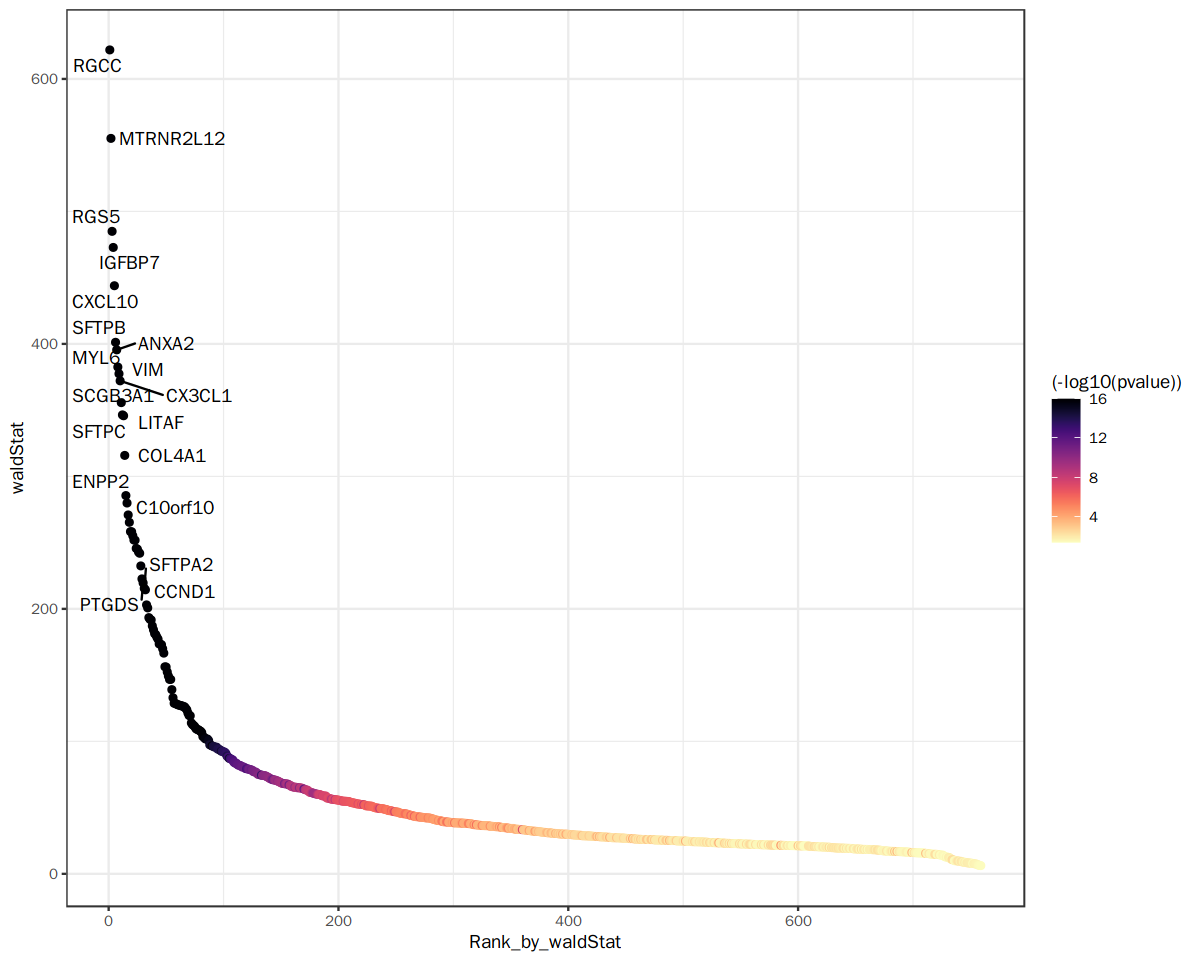

In [155]:
sce1 <- readRDS('l1_tradeseq.rds')
condRes1 <- conditionTest(sce1, l2fc = log2(1.5))
data <- condRes1 %>% rownames_to_column(var='gene')
data <- filter(data, pvalue < 0.05) 
data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
data <- data[order(-data[,2]),]
data$`Rank_by_waldStat` <- 1:length(data[,2])
ggplot(data) + 
    geom_point(mapping=aes(x = Rank_by_waldStat, y = waldStat, colour = (-log10(pvalue)))) + 
    geom_text_repel(label=data$gene,x=data$Rank_by_waldStat, y = data$waldStat) +
    scale_color_viridis(begin=1,end=0,option="A") +
    theme_bw()
ggsave('./figures/conRes1.pdf',width=8,heigh = 5)

Warning message:
“ggrepel: 864 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 874 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


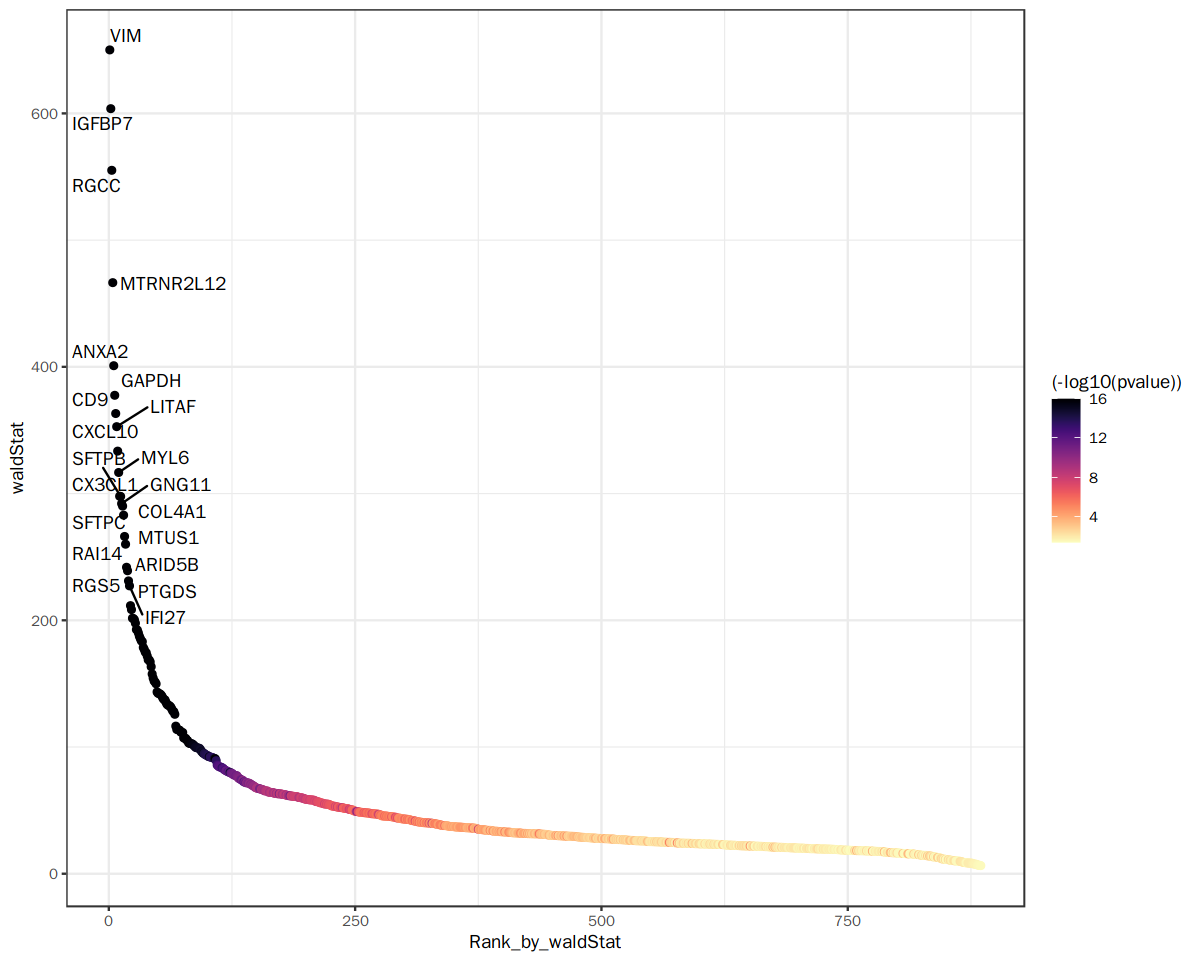

In [156]:
sce2 <- readRDS('l2_tradeseq.rds')
condRes2 <- conditionTest(sce2, l2fc = log2(1.5))
data <- condRes2 %>% rownames_to_column(var='gene')
data <- filter(data, pvalue < 0.05) 
data$pvalue[which(data$pvalue == 0.000000e+00)] <- 1.0e-16
data <- data[order(-data[,2]),]
data$`Rank_by_waldStat` <- 1:length(data[,2])
ggplot(data) + 
    geom_point(mapping=aes(x = Rank_by_waldStat, y = waldStat, colour = (-log10(pvalue)))) + 
    geom_text_repel(label=data$gene,x=data$Rank_by_waldStat, y = data$waldStat) +
    scale_color_viridis(begin=1,end=0,option="A") +
    theme_bw()
ggsave('./figures/conRes2.pdf',width=8,heigh = 5)

In [3]:
# --- Calculate SnnTopGenes
immune <- immune.cluster
res_list <- c("integrated_snn_res.0.1","integrated_snn_res.0.2","integrated_snn_res.0.4","integrated_snn_res.0.8","integrated_snn_res.1.2","integrated_snn_res.1.6",
              "integrated_snn_res.2","integrated_snn_res.3")
for (res in res_list){
    Idents(immune) <- res
    markers <- FindAllMarkers(immune, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
    saveRDS(markers,  file = paste0('./SnnGenes/', res, '.rds.gz'), compress = "gzip")
    }

Idents(immune) <- 'EC_CellType'
markers <- FindAllMarkers(immune, only.pos = FALSE, min.pct = 0.25, logfc.threshold = 0.25)
saveRDS(markers,  file = paste0('./SnnGenes/CellType.rds.gz'), compress = "gzip")

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 7

Calculating cluster 10

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 14

Calculating cluster 16

Calculating cluster 0

Cal

This graph was created by an old(er) igraph version.
ℹ Call `igraph::upgrade_graph()` on it to use with the current igraph version.
For now we convert it on the fly...


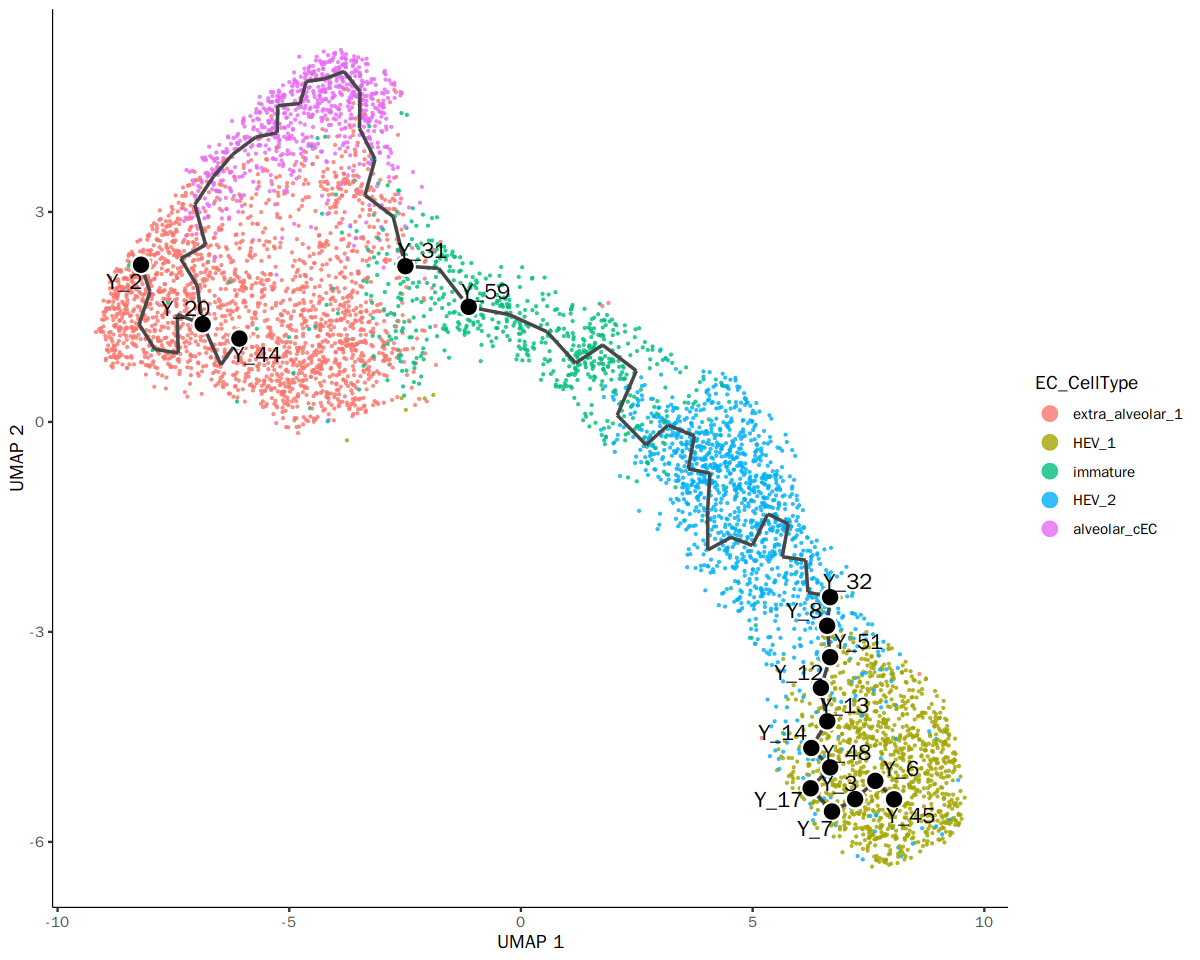

In [5]:
# --- Monocle
library(SingleCellExperiment)
library(SCopeLoomR)
library(monocle3)
cds <- readRDS('./monocle.rds')
fig.size(8,10)
plot_cells(
  cds,
  x = 1,
  y = 2,
  reduction_method = "UMAP",
  color_cells_by = "EC_CellType",
  # group_cells_by = "CellType",
  genes = NULL,
  show_trajectory_graph = TRUE,
  trajectory_graph_color = "grey28",
  trajectory_graph_segment_size = 0.75,
  norm_method = c("log", "size_only"),
  label_cell_groups = FALSE, #TRUE:在图上标注出各个细胞群的名字，FALSE：以图例的形式标注出细胞群的名字。
  label_groups_by_cluster = TRUE, #是否将细胞群的名字标注在每个细胞群落的中心
  group_label_size = 1, #细胞群落名字的标签大小
  labels_per_group = 1,
  label_branch_points = FALSE,#标注出每一个节点的编号：黑色的圆圈显示
  label_roots = TRUE,#标注出每一个根的标号
  label_leaves = TRUE,#标注出每一个细胞群的编号，灰色的圆圈显示
  graph_label_size = 3,#标注的大小
  cell_size = 0.5,
  # cell_stroke = I(cell_size/2),
  alpha = 0.8,
  min_expr = 0.1,
  rasterize = TRUE,
  scale_to_range = TRUE,
  label_principal_points = TRUE #标注出分支的名字，方便后续选取分支进行深入分析
)

In [29]:
# --- Create Scoupe_Loom file
library(SCopeLoomR)
library(hdf5r)
# --- 01 Create a loom file
build_loom(file.name = "immune.loom",
        dgem = immune@assays$RNA@counts,
        title = "endothelial",
        default.embedding = immune@reductions$umap@cell.embeddings,
        default.embedding.name = "umap.rna")

loom <- open_loom("immune.loom", mode = "r+")
# --- 02 Add hierachy
add_hierarchy(
  loom = loom,
  hierarchy = create_hierarchy(
    level.1.name = "SSc-ILD",
    level.2.name = "Lung-endothelial"
  )
)
# --- 03 Add embedding(s)
add_embedding(loom = loom, 
              embedding = immune@reductions$pca@cell.embeddings,
              name = "pca")

# --- 04 Add MetaDate
names(loom[["col_attrs"]])
add_col_attr(loom = loom, key = "Sample", value = immune@meta.data$SamNum, as.annotation = TRUE)
add_col_attr(loom = loom, key = "Group", value = immune@meta.data$Group, as.annotation = TRUE)
add_col_attr(loom = loom, key = "Site", value = immune@meta.data$Site, as.annotation = TRUE)
add_col_attr(loom = loom, key = "Age", value = immune@meta.data$Age, as.annotation = TRUE)
add_col_attr(loom = loom, key = "Gender", value = immune@meta.data$Gender, as.annotation = TRUE)
add_col_attr(loom = loom, key = "Cohort", value = immune@meta.data$Cohort, as.annotation = TRUE)

immune@meta.data$EC_CellType <- as.character(immune@meta.data$EC_CellType)
add_col_attr(loom = loom, key = "CellType", value = immune@meta.data$EC_CellType, as.annotation = TRUE)

names(loom[["col_attrs"]])

# --- 05 Add Seurat clusters and markers
add_seurat_clustering(loom = loom,
        seurat = immune,
        seurat.assay = "RNA",
        seurat.clustering.prefix = "celltype.res.",
        seurat.markers.file.path.list = 
          list(celltype.res.0.1 = './SnnGenes/ct_res.0.1.rds.gz'),
        seurat.marker.metric.accessors = c("avg_log2FC", "p_val"),
        seurat.marker.metric.names = c("Avg. log2FC", "P-value"),
        seurat.marker.metric.description = c("Average log fold change", "Adjusted p-value (BF)")
)

# --- 06 save loom file
close_loom(loom)

[1] "Adding global attributes..."
[1] "Adding matrix..."
  |======================================================================| 100%[1] "Adding column attributes..."
[1] "Adding default metrics nUMI..."
[1] "Adding default metrics nGene..."
[1] "Adding default embedding..."
[1] "Adding row attributes..."
[1] "Adding columns graphs..."
[1] "Adding row graphs..."
[1] "Adding layers..."
[1] "Adding embedding pca..."


[1] "CellID"       "Embedding"    "Embeddings_X" "Embeddings_Y" "nGene"       
[6] "nUMI"

[1] "Age"          "CellID"       "CellType"     "Cohort"       "Embedding"   
 [6] "Embeddings_X" "Embeddings_Y" "Gender"       "Group"        "Sample"      
[11] "Site"         "nGene"        "nUMI"

[1] "Seurat, celltype.res.0.1"
[1] "Adding Seurat clusters..."
[1] "Clusterings created..."
[1] "Clustering ID: 0"
[1] "Adding Seurat markers..."
[1] "Adding markers for clustering 0..."
[1] "Adding metrics for clustering 0..."
